<a href="https://colab.research.google.com/github/audalsgh/20250811/blob/main/0811_ADAS_PyTorch_TensorRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ PyTorch: 2.6.0+cu124
✅ CUDA available: True
✅ GPU: Tesla T4
📦 Loading YOLOv8n...
✅ FP32 model ready on cuda
✅ FP16 model ready on cuda

🚗 Image: 1.jpg
🔥 FP32 benchmark
  Iter 5/10: 0.0135s  (73.8 FPS)
  Iter 10/10: 0.0141s  (71.0 FPS)
⚡ FP16 benchmark
  Iter 5/10: 0.0138s  (72.7 FPS)
  Iter 10/10: 0.0152s  (66.0 FPS)


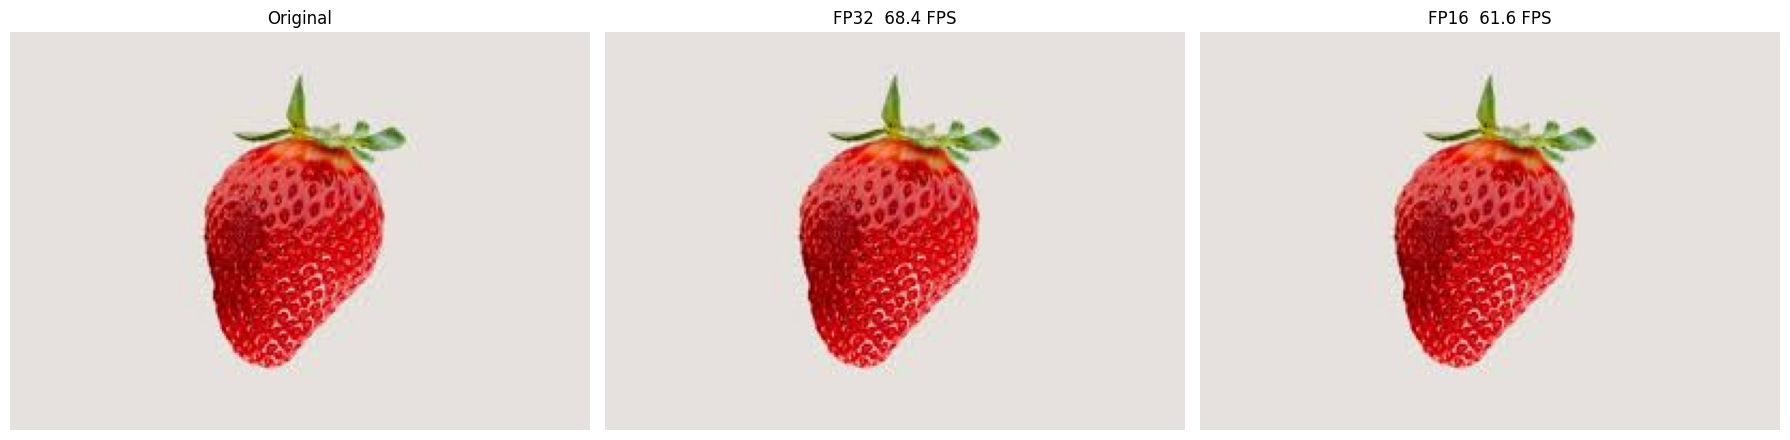

📊 Result: FP32 68.35 FPS (14.6 ms)  |  FP16 61.62 FPS (16.2 ms)  →  Improvement: -9.8%

🚗 Image: 2.jpg
🔥 FP32 benchmark
  Iter 5/10: 0.0121s  (82.7 FPS)
  Iter 10/10: 0.0158s  (63.1 FPS)
⚡ FP16 benchmark
  Iter 5/10: 0.0120s  (83.3 FPS)
  Iter 10/10: 0.0123s  (81.4 FPS)


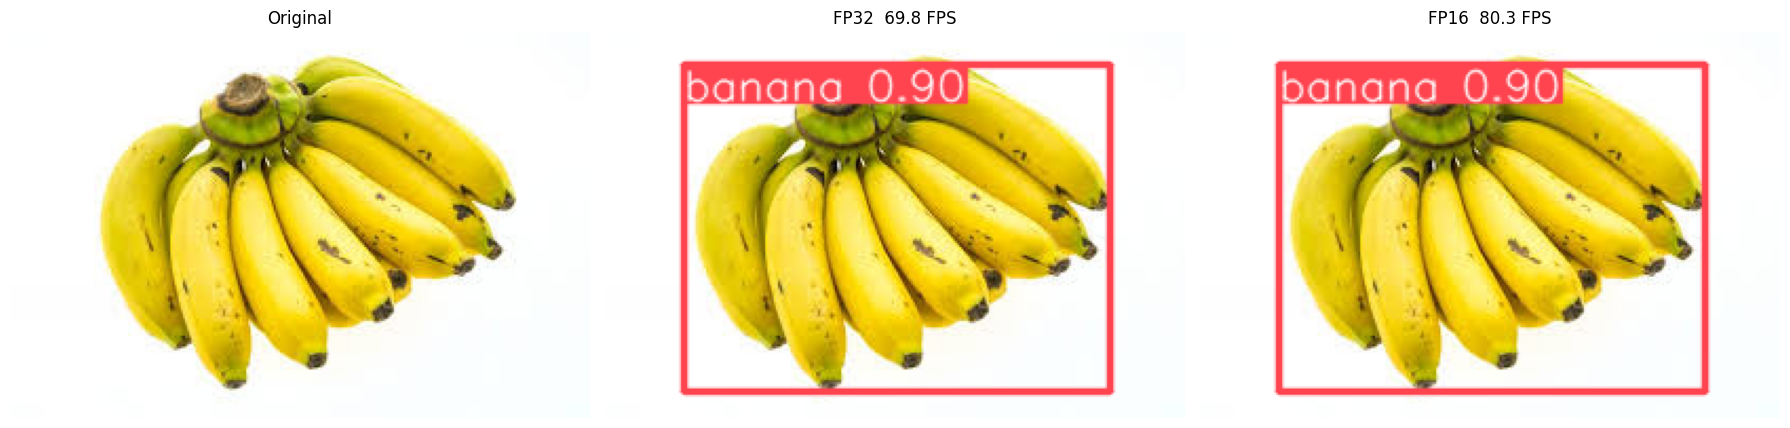

📊 Result: FP32 69.81 FPS (14.3 ms)  |  FP16 80.30 FPS (12.5 ms)  →  Improvement: 15.0%

🚗 Image: 3.jpg
🔥 FP32 benchmark
  Iter 5/10: 0.0120s  (83.3 FPS)
  Iter 10/10: 0.0143s  (70.0 FPS)
⚡ FP16 benchmark
  Iter 5/10: 0.0124s  (80.7 FPS)
  Iter 10/10: 0.0119s  (84.2 FPS)


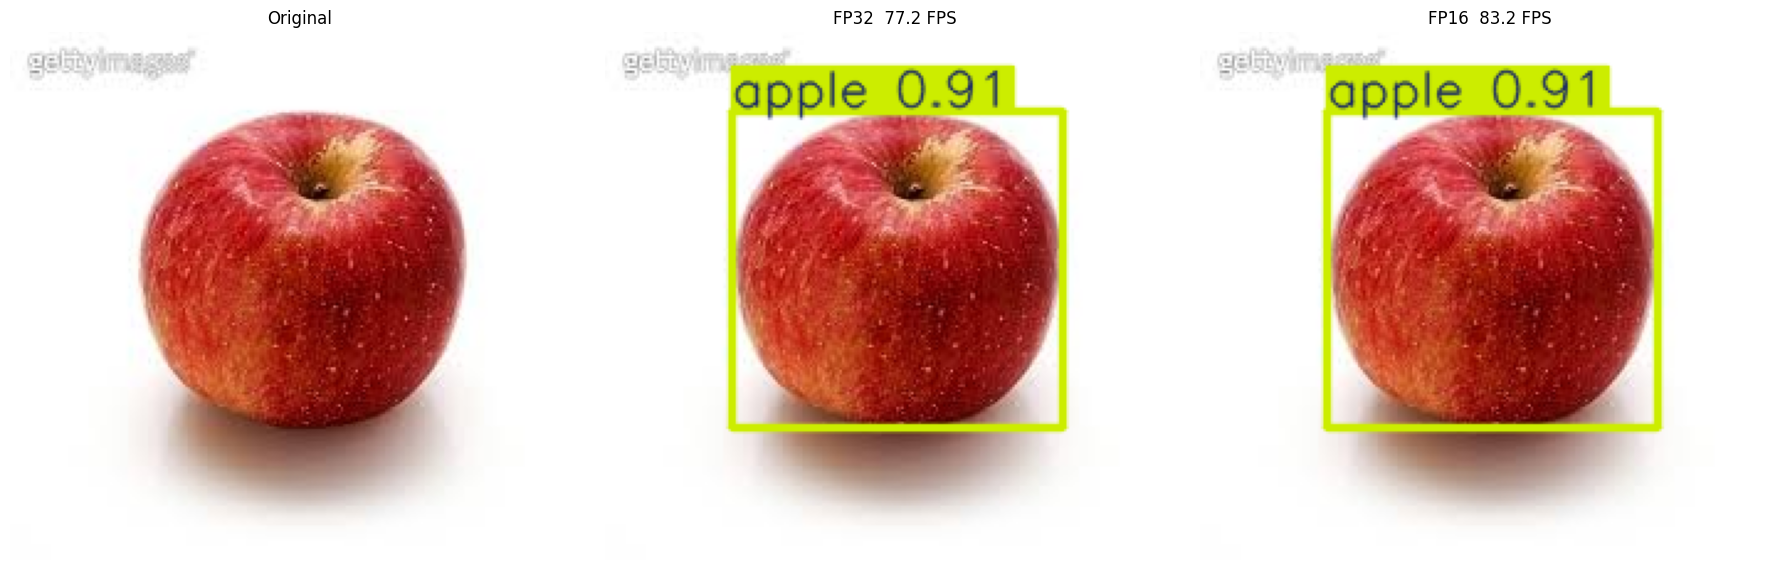

📊 Result: FP32 77.20 FPS (13.0 ms)  |  FP16 83.20 FPS (12.0 ms)  →  Improvement: 7.8%

================ Overall Summary ================
Processed images: 3
FP32 avg FPS: 71.79
FP16 avg FPS: 75.04
Average Improvement: 4.5%


In [1]:
# =========================
# PyTorch FP32 vs FP16 Speed Benchmark (YOLOv8n)
# =========================

# 0) Install deps (Colab-safe)
import sys, subprocess
def pip_install(pkg):
    try:
        __import__(pkg.split('==')[0].replace('-', '_'))
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

pip_install("opencv-python-headless")
pip_install("numpy")
pip_install("matplotlib")
pip_install("ultralytics")

# 1) Imports
import os, time
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 2) System info
print("✅ PyTorch:", torch.__version__)
print("✅ CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("✅ GPU:", torch.cuda.get_device_name(0))
device = "cuda" if torch.cuda.is_available() else "cpu"

# 3) Images to test
CANDIDATES = ["1.jpg", "2.jpg", "3.jpg"]
images = [f for f in CANDIDATES if os.path.exists(f)]
if not images:
    print("⚠️ 현재 폴더에서 1.jpg, 2.jpg, 3.jpg 를 찾지 못했습니다. 데모를 건너뜁니다.")

# 4) Load models (FP32 & FP16)
print("📦 Loading YOLOv8n...")
model_fp32 = YOLO("yolov8n.pt")
model_fp32.to(device)
print("✅ FP32 model ready on", device)

# FP16은 GPU에서만 가능
model_fp16 = None
if device == "cuda":
    model_fp16 = YOLO("yolov8n.pt")
    model_fp16.to("cuda")
    # 강제로 half precision
    model_fp16.model.half()
    print("✅ FP16 model ready on cuda")
else:
    print("⚠️ GPU가 없어 FP16 비교는 불가합니다. FP32만 측정합니다.")

# 5) Benchmark util
def benchmark(model, source, iters=10, conf=0.5, warmup=3):
    # warmup
    for _ in range(warmup):
        _ = model(source, conf=conf, verbose=False)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    times = []
    for i in range(iters):
        t0 = time.time()
        results = model(source, conf=conf, verbose=False)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        dt = time.time() - t0
        times.append(dt)
        if (i+1) % max(1, iters//2) == 0:
            print(f"  Iter {i+1}/{iters}: {dt:.4f}s  ({1.0/dt:.1f} FPS)")

    times = np.array(times, dtype=np.float64)
    avg_t, std_t = times.mean(), times.std()
    fps = 1.0 / avg_t
    return {
        "avg_time": avg_t,          # seconds
        "std_time": std_t,          # seconds
        "avg_fps": fps,
        "times": times,
        "last_results": results     # keep last to visualize
    }

# 6) Run per image
if images:
    overall = []
    for img_path in images:
        print(f"\n🚗 Image: {img_path}")

        print("🔥 FP32 benchmark")
        fp32 = benchmark(model_fp32, img_path, iters=10, conf=0.5, warmup=3)

        if model_fp16 is not None:
            print("⚡ FP16 benchmark")
            fp16 = benchmark(model_fp16, img_path, iters=10, conf=0.5, warmup=3)
        else:
            fp16 = None

        # Visualization (Original / FP32 / FP16)
        src = cv2.imread(img_path)
        if src is None:
            print("❌ 이미지를 읽지 못했습니다:", img_path)
            continue

        vis32 = fp32["last_results"][0].plot()  # BGR ndarray
        vis16 = fp16["last_results"][0].plot() if fp16 is not None else None

        cols = 3 if vis16 is not None else 2
        plt.figure(figsize=(6*cols, 6))
        plt.subplot(1, cols, 1); plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
        plt.subplot(1, cols, 2); plt.imshow(cv2.cvtColor(vis32, cv2.COLOR_BGR2RGB)); plt.title(f"FP32  {fp32['avg_fps']:.1f} FPS"); plt.axis("off")
        if vis16 is not None:
            plt.subplot(1, cols, 3); plt.imshow(cv2.cvtColor(vis16, cv2.COLOR_BGR2RGB)); plt.title(f"FP16  {fp16['avg_fps']:.1f} FPS"); plt.axis("off")
        plt.tight_layout(); plt.show()

        # Console summary
        if fp16 is not None:
            gain = (fp16["avg_fps"]/fp32["avg_fps"] - 1.0) * 100.0
            print(f"📊 Result: FP32 {fp32['avg_fps']:.2f} FPS ({fp32['avg_time']*1000:.1f} ms)  |  "
                  f"FP16 {fp16['avg_fps']:.2f} FPS ({fp16['avg_time']*1000:.1f} ms)  →  "
                  f"Improvement: {gain:.1f}%")
            overall.append((fp32["avg_fps"], fp16["avg_fps"]))
        else:
            print(f"📊 Result: FP32 {fp32['avg_fps']:.2f} FPS ({fp32['avg_time']*1000:.1f} ms)")
            overall.append((fp32["avg_fps"], None))

    # Overall summary
    print("\n================ Overall Summary ================")
    n = len(overall)
    fp32_vals = [x for x,_ in overall if x is not None]
    fp16_vals = [y for _,y in overall if y is not None]
    print(f"Processed images: {n}")
    print(f"FP32 avg FPS: {np.mean(fp32_vals):.2f}")
    if fp16_vals:
        print(f"FP16 avg FPS: {np.mean(fp16_vals):.2f}")
        print(f"Average Improvement: {(np.mean(fp16_vals)/np.mean(fp32_vals)-1)*100:.1f}%")
    else:
        print("FP16: not available (no CUDA).")
else:
    print("\n(참고) 이미지가 없어서 벤치마크를 실행하지 않았습니다. 1.jpg~3.jpg를 업로드하세요.")